In [19]:
import cv2
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
#from scipy import misc
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
from PIL import Image
import six
from io import StringIO

In [20]:
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2

In [21]:
# initializing the centroids
k=3
n_colors=k
C_x = np.random.randint(0, 500, size=k)
C_y = np.random.randint(0, 500, size=k)
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
print(C)

[[180. 147.]
 [267. 132.]
 [158. 332.]]


In [22]:
#image = misc.imread('desktop/baboon.jpg')
#print(image)
#print(image.shape)

In [23]:
image = cv2.imread('baboon.jpg')



In [24]:
# Seperating width height and no. of channels
w, h, d = original_shape = tuple(image.shape)
print("Widht:",w)
print("Height:",h)
print("Channels/Dimension:",d)
print("Each channel for RGB and Range is [0 -255]")
print("If each channel required 1 byte of space which means 3 bytes for each pixel")
print("\nThen for whole image it will require {} x {} x {} = {} bytes".format(w,h,d,w*h*d))
print("Which comes around {} Mb".format((w*h*d)/(10000000)))

Widht: 512
Height: 512
Channels/Dimension: 3
Each channel for RGB and Range is [0 -255]
If each channel required 1 byte of space which means 3 bytes for each pixel

Then for whole image it will require 512 x 512 x 3 = 786432 bytes
Which comes around 0.0786432 Mb


In [25]:
image = np.array(image, dtype=np.float64) / 255
assert d == 3 #The code forward runs for 3 channel only

In [26]:
image_array = np.reshape(image, (w * h, d))
print(image_array)
print(image_array.shape)

[[0.38039216 0.59607843 0.61568627]
 [0.06666667 0.22745098 0.28627451]
 [0.01568627 0.16862745 0.22745098]
 ...
 [0.         0.02745098 0.02352941]
 [0.00392157 0.03529412 0.0627451 ]
 [0.         0.         0.03529412]]
(262144, 3)


In [27]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [28]:
print("Fitting model on a small sub-sample of the data")

t0 = time() #has time in seconds since epoch(1970)

#Take only 2000 random points to train our k-means 
image_array_sample = shuffle(image_array, random_state=0)[:2000]

#Using k-means to create k(64) clusters
#Cluster of close RGB colour are grouped together and labeled using their centroid(geometric mean)
kmeans = KMeans(n_clusters=3, random_state=0)
knnsample = kmeans.fit(image_array_sample)

#total seconds taken for fitting
print("done in %0.3fs." % (time() - t0)) 
# print("Sample Array size:",image_array_sample.shape)

#print("\nK means Labels:\n",kmeans.labels_)
#print("\nCluster Centers/ Centroids:\n",kmeans.cluster_centers_[:5])

Fitting model on a small sub-sample of the data
done in 0.055s.


In [29]:
# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array) # Compute cluster centers and predict cluster index for each sample.
print("done in %0.3fs." % (time() - t0))
print("Predicted Labels:",labels)

Predicting color indices on the full image (k-means)
done in 0.051s.
Predicted Labels: [2 1 1 ... 1 1 1]


In [30]:
#Taking random 64 points from top 1000 array elements
codebook_random = shuffle(image_array[:1000], random_state=0)[:n_colors + 1]

print(codebook_random[:5])
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,image_array,axis=0)
print("done in %0.3fs." % (time() - t0))
print(labels_random)

[[0.38039216 0.46666667 0.35686275]
 [0.46666667 0.5372549  0.38431373]
 [0.72941176 0.71372549 0.67058824]
 [0.04705882 0.17254902 0.21568627]]
Predicting color indices on the full image (random)
done in 0.044s.
[1 3 3 ... 3 3 3]


In [31]:
#Taking random 64 points from top 1000 array elements
codebook_random2 = shuffle(image_array, random_state=0)[:n_colors + 1]

print(codebook_random2[:5])
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random2 = pairwise_distances_argmin(codebook_random2,image_array,axis=0)
print("done in %0.3fs." % (time() - t0))
print(labels_random2)

[[0.34117647 0.4627451  0.45098039]
 [0.0627451  0.24705882 0.97647059]
 [0.55294118 0.6        0.67058824]
 [0.2745098  0.3372549  0.30980392]]
Predicting color indices on the full image (random)
done in 0.038s.
[2 3 3 ... 3 3 3]


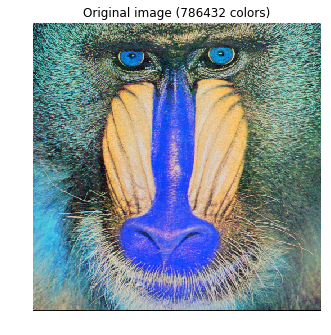

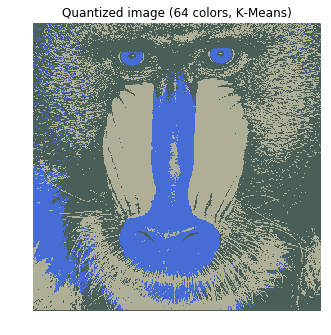

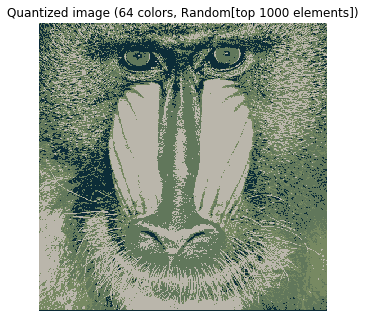

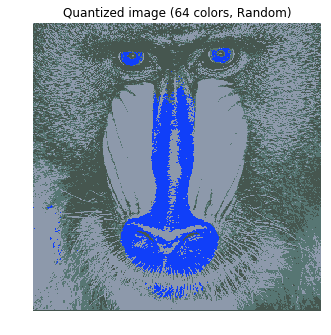

-1

In [40]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    #For each pixel setting the color of its nearest cluster mean
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Displaying original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
s= "Original image ("+(str)(w*h*d)+" colors)"
plt.title(s)
plt.imshow(image)

cv2.imshow("image",image)
cv2.waitKey(0)

#Displaying Image using k-means with 64 colors
plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h)) # Coordinates of cluster centers ie means coordinates

cv2.imshow("image", recreate_image(kmeans.cluster_centers_, labels, w, h))
cv2.waitKey(0)

#Displaying Image using Random Algorithm top 1000 elements
plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, Random[top 1000 elements])')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))

cv2.imshow("image", recreate_image(codebook_random, labels_random, w, h))
cv2.waitKey(0)

#Displaying Image using Random Algorithm whole array
plt.figure(4)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random2, labels_random2, w, h))
plt.show()

cv2.imshow("image", recreate_image(codebook_random2, labels_random2, w, h))
cv2.waitKey(0)

In [38]:
print((kmeans.cluster_centers_))

[[0.68779318 0.68535032 0.58920944]
 [0.29518081 0.37362617 0.3517661 ]
 [0.2759568  0.42660166 0.84018035]]
